In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/tf_examples 

/content/gdrive/MyDrive/tf_examples


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                              with_info=True, as_supervised=True)

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteE76RUY/cycle_gan-trainB.tfrecord*...…

Generating testA examples...:   0%|          | 0/120 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteE76RUY/cycle_gan-testA.tfrecord*...:…

Generating testB examples...:   0%|          | 0/140 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteE76RUY/cycle_gan-testB.tfrecord*...:…

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0. Subsequent calls will reuse this data.


In [ ]:
print(len(train_horses))
print(type(train_horses))

1067
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def random_crop(image):
    cropped_image = tf.image.random_crop(
    image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image

In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [ ]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [ ]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [ ]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [ ]:
train_horses1 = train_horses.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_zebras1 = train_zebras.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_horses1 = test_horses.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_zebras1 = test_zebras.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
print(len(train_horses1))
print(type(train_horses1))
print(train_horses1.element_spec)

1067
<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)


In [ ]:
image, label = next(iter(train_horses))

In [ ]:
## Showing the two images
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)
  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

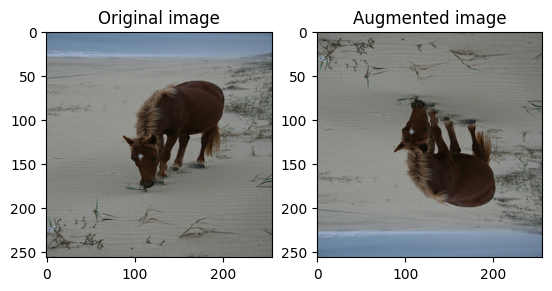

In [ ]:
flip_up = tf.image.flip_up_down(image)
visualize(image, flip_up)

In [ ]:
## Data Augmentation 1
def augmented_image_1(image,label):
    # Random horizontal flipping
    image = tf.image.flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image)
    image = tf.image.adjust_saturation(image, 2)
    image = tf.image.adjust_brightness(image, 0.2)
    # image = tf.image.central_crop(image, central_fraction=0.6)
    image = random_crop(image)
    # Scaling pixel values to [-1, 1]
    image = normalize(image)
    return image

# Apply data augmentation to the horse images in the training set
train_horses_augmented_1 = train_horses.map(augmented_image_1,num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)
train_zebras_augmented_1 = train_zebras.map(augmented_image_1,num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
print(train_horses_augmented_1.element_spec)

TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)


In [ ]:
## Data Augmentation 2
def augmented_image_2(image,label):
    # Random vertical flipping
    image = tf.image.flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.rot90(image)
    image = tf.image.adjust_brightness(image, 0.2)
    image = tf.image.adjust_contrast(image, contrast_factor=1.2)
    image = random_crop(image)
    # Scaling pixel values to [-1, 1]
    image = normalize(image)
    return image

# Apply data augmentation to the horse images in the training set
train_horses_augmented_2 = train_horses.map(augmented_image_2,num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)
train_zebras_augmented_2 = train_zebras.map(augmented_image_2,num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
#Concatenate the datasets

concatenated_train_horse = train_horses1.concatenate(train_horses_augmented_1.take(500))
concatenated_train_horse = concatenated_train_horse.concatenate(train_horses_augmented_2.take(500))
concatenated_train_zebra = train_zebras1.concatenate(train_zebras_augmented_1.take(500))
concatenated_train_zebra = concatenated_train_zebra.concatenate(train_zebras_augmented_2.take(500))

print(len(concatenated_train_horse))
print(type(concatenated_train_horse))
print(concatenated_train_horse.element_spec)

print(len(concatenated_train_zebra))


2067
<class 'tensorflow.python.data.ops.concatenate_op._ConcatenateDataset'>
TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)
2334


In [ ]:
sample_horse = next(iter(concatenated_train_horse))
sample_zebra = next(iter(concatenated_train_zebra))
# sample_aug_horse = next(iter(train_horses_augmented))
# sample_con_horse = next(iter(concatenated_train_horse))

Text(0.5, 1.0, 'Horse with Random Jitter')

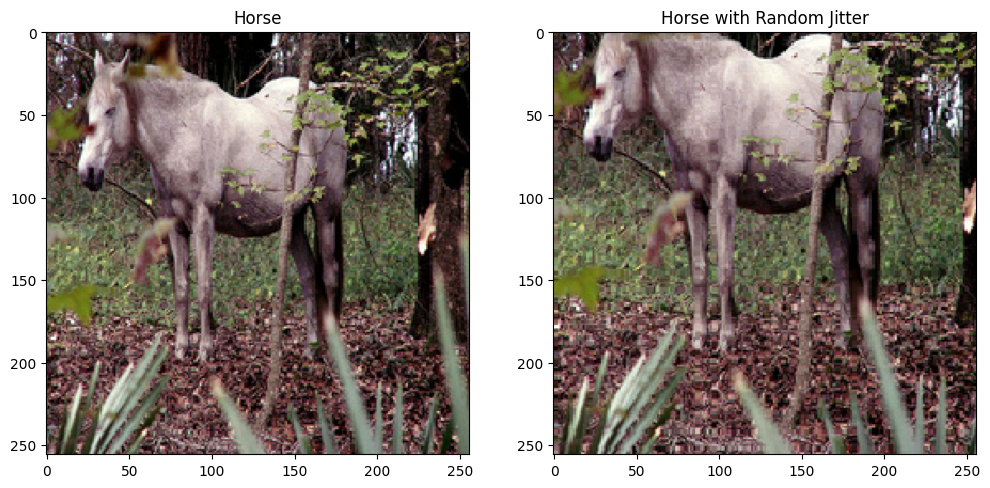

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# Plot the first image in the first subplot
ax[0].imshow(sample_horse[0] * 0.5 + 0.5)
ax[0].set_title("Horse")

# Plot the second image in the second subplot
ax[1].imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)
ax[1].set_title("Horse with Random Jitter")

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# Plot the first image in the first subplot
ax[0].imshow(sample_zebra[0] * 0.5 + 0.5)
ax[0].set_title("Zebra")

# Plot the second image in the second subplot
ax[1].imshow(random_jitter(sample_zebra[0]) * 0.5 + 0.5)
ax[1].set_title("Zebra with Random Jitter")

Text(0.5, 1.0, 'Zebra with Random Jitter')

## Modified Generator

In [ ]:
!pip install -U tensorflow-addons

In [ ]:
from random import random
from numpy import load
from numpy import zeros
import numpy as np
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from tensorflow_addons.layers import InstanceNormalization
from matplotlib import pyplot
from tensorflow.keras import layers

In [ ]:
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02,seed=None)
	# first convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

In [ ]:
def define_generator1(image_shape, n_resnet=2):
	# weight initialization
	init = RandomNormal(stddev=0.02,seed=None)
	# image input
	in_image = Input(shape=image_shape,name='input1')
	print("Input layer Resnet",in_image.shape)

	##RESNET
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init,name='conv1')(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	print("1st layer Resnet",g.shape)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init,name='conv2')(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	print("2nd layer Resnet",g.shape)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init,name='conv3')(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	print("3rd layer Resnet",g.shape)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	print('After adding resent block',g.shape) #64,64,2560

	g = Conv2D(512, (3,3), strides=(1,1), padding='same', kernel_initializer=init,name='conv4')(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	print(g.shape)

	g = Conv2D(256, (3,3), strides=(1,1), padding='same', kernel_initializer=init,name='conv5')(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	print(g.shape)

	print("Final Resnet",g.shape)

	##U-NET

	# c7s1-64
	g1 = Conv2D(64, (4,4), padding='same', kernel_initializer=init,name='conv8')(in_image)
	g1 = InstanceNormalization(axis=-1)(g1)
	g1 = Activation('relu')(g1)
	print("1st layer Unet",g1.shape)

	# d128
	g2 = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init,name='conv9')(g1)
	g2 = InstanceNormalization(axis=-1)(g2)
	g2 = Activation('relu')(g2)
	print("2nd layer Unet",g2.shape)

	# d256
	g3 = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init,name='conv10')(g2)
	g3 = InstanceNormalization(axis=-1)(g3)
	g3 = Activation('relu')(g3)
	print("3rd layer Unet",g3.shape)


	print('unet downsample shape',g1.shape)


	## Conctenate
	combined_feature_map = Concatenate()([g, g3]) # 64,64,512
	print("Combined Feature map",combined_feature_map)

	g = Conv2DTranspose(512, (3,3), strides=(2,2), padding='same', kernel_initializer=init,name='conv15')(combined_feature_map) #128,128,512
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	print(g.shape)
	g = Conv2DTranspose(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init,name='conv16')(g) #256,256,256
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	print(g.shape)

	
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init,name='conv20')(g) #256,256,3
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	print(g.shape)
	
	
	out_image = Activation('tanh')(g)
	print("Out_image - ",out_image.shape)
	model = Model(in_image, out_image)
	return model

In [ ]:
modified_generator = define_generator1((256,256,3))

Input layer Resnet (None, 256, 256, 3)
1st layer Resnet (None, 256, 256, 64)
2nd layer Resnet (None, 128, 128, 128)
3rd layer Resnet (None, 64, 64, 256)


/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


After adding resent block (None, 64, 64, 768)
(None, 64, 64, 512)
(None, 64, 64, 256)
Final Resnet (None, 64, 64, 256)
1st layer Unet (None, 256, 256, 64)
2nd layer Unet (None, 128, 128, 128)
3rd layer Unet (None, 64, 64, 256)
unet downsample shape (None, 256, 256, 64)
Combined Feature map KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 512), dtype=tf.float32, name=None), name='concatenate_2/concat:0', description="created by layer 'concatenate_2'")
(None, 128, 128, 512)
(None, 256, 256, 256)
(None, 256, 256, 3)
Out_image -  (None, 256, 256, 3)


In [ ]:
dataset, info = tfds.load('cycle_gan/horse2zebra', with_info=True, as_supervised=True)
train_horses11, train_zebras11 = dataset['trainA'], dataset['trainB']
test_horses11, test_zebras11 = dataset['testA'], dataset['testB']

# # Preprocess the images
# def preprocess(image, label):
#     image = tf.image.resize(image, [256, 256])
#     image = tf.cast(image, tf.float32)
#     image = (image / 127.5) - 1
#     return image, label

# train_horses11 = train_horses11.map(preprocess)
# train_zebras11 = train_zebras11.map(preprocess)
# test_horses11 = test_horses11.map(preprocess)
# test_zebras11 = test_zebras11.map(preprocess)



# # Define the input shape
# input_shape = (256, 256, 3)

# # Define the model architecture
# model = tf.keras.Sequential([
#     # Convolutional layer 1
#     layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D((2, 2)),
#     # Convolutional layer 2
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D((2, 2)),
#     # Convolutional layer 3
#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D((2, 2)),
#     # Flatten the output of the convolutional layers
#     layers.Flatten(),
#     # Fully connected layer 1
#     layers.Dense(256, activation='relu'),
#     # Fully connected layer 2
#     layers.Dense(128, activation='relu'),
#     # Output layer
#     layers.Dense(1, activation='sigmoid')
# ])

# # Compile the model
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# # Prepare the training data
# train_horses_labeled = train_horses11.map(lambda x, y: (x, 0))
# train_zebras_labeled = train_zebras11.map(lambda x, y: (x, 1))
# train_data = train_horses_labeled.concatenate(train_zebras_labeled)
# train_data = train_data.shuffle(buffer_size=1000)

# train_images = train_data.map(lambda x, y: x)
# train_labels = train_data.map(lambda x, y: y)

# train_data = tf.data.Dataset.zip((train_images, train_labels))
# train_data = train_data.shuffle(buffer_size=1000)


# batch_size = 32  # set your desired batch size here
# train_data = train_data.batch(batch_size)

# num_samples = len(train_data)
# train_size = int(0.8 * num_samples)

# train_dataset5 = train_data.take(train_size)
# validation_dataset5 = train_data.skip(train_size)

# print("deva=",train_dataset5.element_spec)


# # Train the model
# # history = model.fit(train_data1, epochs=10)

# history = model.fit(train_dataset5, epochs=10, validation_data=validation_dataset5,verbose=0)


In [ ]:
# Prepare the testing data
test_horses = test_horses11.map(lambda x, y: (x, 0))
test_zebras = test_zebras11.map(lambda x, y: (x, 1))
test_data = test_horses11.concatenate(test_zebras11)
test_data = test_data.shuffle(buffer_size=1000)


test_data = test_data.batch(32)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_data, verbose = 0)

## Initializing the Generator

In [ ]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)
print("executed the cell")

executed the cell


In [ ]:
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']
plt.figure(figsize=(12, 12))

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

NameError: ignored

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(13, 6))
# Plot the first image in the first subplot
ax[0].imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')
ax[0].set_title("Is a real zebra?")

# Plot the second image in the second subplot
ax[1].imshow(discriminator_x(sample_horse)[0, ..., -1], cmap='RdBu_r')
ax[1].set_title("Is a real horse?")

Text(0.5, 1.0, 'Is a real horse?')

In [ ]:
LAMBDA = 10

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
print("executed the cell")

executed the cell


In [ ]:
checkpoint_path = "/content/gdrive/My Drive/Cyclegan/checkpoints/Horse2Zebra_1"
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [ ]:
EPOCHS = 12

In [ ]:
# Evaluation matrics
import cv2
import numpy as np

# IOU function
def calc_iou_score(pred, true):
    
#    intersection = np.sum(pred[true==k]) * 2.0
#    dice_score = intersection / (np.sum(pred) + np.sum(true))
#    return dice_score

#    intersection = np.intersect1d(pred, true)
#    union = np.union1d(pred, true)
#    dice = intersection.shape[0] / union.shape[0]
    
    pred = pred.numpy()
    true = true.numpy()
    
    intersection_res = (np.abs(pred - true) < 0.1) * 1
    # print(intersection_res)
    union_res = np.logical_or(pred,true) * 1
    # print(union_res)
    # print(np.sum(intersection_res))
    # print(np.sum(union_res))
    iou_score = np.sum(intersection_res) / np.sum(union_res)
    # print(iou_score)
    
    # print(pred - true)


#     y_true_f = tf.reshape(tf.dtypes.cast(true, tf.float32), [-1])
#     y_pred_f = tf.reshape(tf.dtypes.cast(pred, tf.float32), [-1])
#     intersection = tf.reduce_sum(y_true_f * y_pred_f)
#     res = (2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.)
#     return res

    return iou_score

def cycle_generate_images(model1, model2, test_input,filename,path):
  prediction = model1(test_input)
  reconstructed = model2(prediction)
    
  #   print(test_input)
  #   print(reconstructed)

  iou_score = calc_iou_score(test_input,reconstructed)
  plt.figure(figsize=(35, 35))

  display_list = [test_input[0], prediction[0], reconstructed[0]]
  title = ['Input Image', 'Predicted Image', 'Reconstructed Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  # filename1 = '%s_generated_plot_%04d.png' % ('AtoBtoA', (step+1))
  # plt.savefig('/content/gdrive/My Drive/Cyclegan/' + filename1, dpi = 300)
  plt.savefig(path + filename, dpi = 300)
  plt.show()
  plt.close()
  print(iou_score)


def generate_images(model1,test_input,step):
  prediction = model1(test_input)
      
  #   print(test_input)
  #   print(reconstructed)

  plt.figure(figsize=(20, 20))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  filename1 = '%s_generated_plot_%04d.jpg' % ('AtoB', (step+1))
  plt.savefig('/content/gdrive/My Drive/Cyclegan/' + filename1)
  plt.show()
  plt.close()

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  loss_arr = []
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss + identity loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
    
    loss_arr.append([total_cycle_loss, total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss])
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

  return loss_arr

In [ ]:
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [ ]:
wts_bef = (generator_g.layers[5].weights[0].numpy())
wts_bef[0]

In [ ]:
cycle_loss = []
genG_loss = []
genF_loss = []
disX_loss = []
disY_loss = []

for epoch in range(EPOCHS):
  start = time.time()
  loss_arr = []
  n = 0
  for image_x, image_y in tf.data.Dataset.zip((concatenated_train_horse, concatenated_train_zebra)):
    loss_arr.append(train_step(image_x, image_y))
    if n % 30 == 0:
      print ('.', end='')
    n += 1
  # calculating the avraege loss and storing it in respective lists
  loss_arr = np.array(loss_arr)
  cycle_loss.append(np.mean(loss_arr[:len(loss_arr),0,0]))
  genG_loss.append(np.mean(loss_arr[:len(loss_arr),0,1]))
  genF_loss.append(np.mean(loss_arr[:len(loss_arr),0,2]))
  disX_loss.append(np.mean(loss_arr[:len(loss_arr),0,3]))
  disY_loss.append(np.mean(loss_arr[:len(loss_arr),0,4]))
  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  if (epoch + 1) % 5 == 0:
    sample_horse = next(iter(concatenated_train_horse))
    filename1 = '%s_Train_%04d.png' % ('H2Z2H', (epoch+1))
    fig_path = '/content/gdrive/My Drive/Cyclegan/Horse2Zebra/Train_Images_H2Z_1/'
    filename2 = '%s_Train_%04d.png' % ('Z2H2Z', (epoch+1))
    cycle_generate_images(generator_g,generator_f,sample_horse,filename1,fig_path)
    cycle_generate_images(generator_f,generator_g,sample_zebra,filename2,fig_path)

  if (epoch + 1) % 2 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

In [ ]:
print(len(genF_loss))

In [ ]:
with open('/content/gdrive/My Drive/Cyclegan/cycle_loss.txt', 'a') as f:
  # Write each element of the list to a new line in the file
  for item in cycle_loss:
    f.write("%s\n" % item)

with open('/content/gdrive/My Drive/Cyclegan/genG_loss.txt', 'a') as f1:
  # Write each element of the list to a new line in the file
  for item in genG_loss:
    f1.write("%s\n" % item)

with open('/content/gdrive/My Drive/Cyclegan/genF_loss.txt', 'a') as f2:
  # Write each element of the list to a new line in the file
  for item in genF_loss:
    f2.write("%s\n" % item)

with open('/content/gdrive/My Drive/Cyclegan/disX_loss.txt', 'a') as f3:
  # Write each element of the list to a new line in the file
  for item in disX_loss:
    f3.write("%s\n" % item)

with open('/content/gdrive/My Drive/Cyclegan/disY_loss.txt', 'a') as f4:
  # Write each element of the list to a new line in the file
  for item in disY_loss:
    f4.write("%s\n" % item)

In [ ]:
# Open the file for reading
with open('/content/gdrive/My Drive/Cyclegan/cycle_loss.txt', 'r') as f:
  # Read the contents of the file into a list
  cycle_loss1 = [float(line.strip()) for line in f.readlines()]

with open('/content/gdrive/My Drive/Cyclegan/genG_loss.txt', 'r') as f1:
  # Read the contents of the file into a list
  genG_loss1 = [float(line.strip()) for line in f1.readlines()]

with open('/content/gdrive/My Drive/Cyclegan/genF_loss.txt', 'r') as f2:
  # Read the contents of the file into a list
  genF_loss1 = [float(line.strip()) for line in f2.readlines()]

with open('/content/gdrive/My Drive/Cyclegan/disX_loss.txt', 'r') as f3:
  # Read the contents of the file into a list
  dissX_loss1 = [float(line.strip()) for line in f3.readlines()]

with open('/content/gdrive/My Drive/Cyclegan/disY_loss.txt', 'r') as f4:
  # Read the contents of the file into a list
  dissY_loss1 = [float(line.strip()) for line in f4.readlines()]


In [ ]:
print(len(cycle_loss1))
print(len(genG_loss1))
print(len(genF_loss1))
print(len(dissX_loss1))
print(len(dissY_loss1))

In [ ]:
plt.plot(cycle_loss1)
plt.title('Cycle Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Cycle loss'], loc='upper right')
plt.savefig('/content/gdrive/My Drive/Cyclegan/Graphs/CycleLoss')
plt.show()

plt.plot(genG_loss1)
plt.title('Generator G Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Generator G loss'], loc='upper left')
plt.savefig('/content/gdrive/My Drive/Cyclegan/Graphs/GenGLoss')
plt.show()

plt.plot(genF_loss1)
plt.title('Generator F Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Generator F loss'], loc='upper right')
plt.savefig('/content/gdrive/My Drive/Cyclegan/Graphs/GenFLoss')
plt.show()

plt.plot(dissX_loss1)
plt.title('Discriminator X Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Discriminator X loss'], loc='upper right')
plt.savefig('/content/gdrive/My Drive/Cyclegan/Graphs/DissXLoss')
plt.show()

plt.plot(dissY_loss1)
plt.title('Discriminator Y Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Discriminator Y loss'], loc='upper right')
plt.savefig('/content/gdrive/My Drive/Cyclegan/Graphs/DissyLoss')
plt.show()

In [ ]:
def display_images(model1, model2, test_input,x):
  prediction = model1(test_input)
  reconstructed = model2(prediction)
    
  #   print(test_input)
  #   print(reconstructed)

  # iou_score = calc_iou_score(test_input,reconstructed)
  # plt.figure(figsize=(35, 35))


  filename1 = '%s_Test_%04d.png' % ('Inp_H', (x))
  path1 = '/content/gdrive/My Drive/Cyclegan/Z2H/Inp_Z/'
  plt.imshow(test_input[0] * 0.5 + 0.5)
  plt.title('Input Image')
  plt.axis('off')
  plt.savefig(path1 + filename1, dpi = 150)
  plt.show()
  
  filename2 = '%s_Test_%04d.png' % ('H_Z', (x))
  path2 = '/content/gdrive/My Drive/Cyclegan/Z2H/Z_H/'
  plt.imshow(prediction[0] * 0.5 + 0.5)
  plt.title('Predicted Image')
  plt.axis('off')
  plt.savefig(path2 + filename2, dpi = 150)
  plt.show()

  filename3 = '%s_Test_%04d.png' % ('H_Z_H', (x))
  path3 = '/content/gdrive/My Drive/Cyclegan/Z2H/Z_H_Z/'
  plt.imshow(reconstructed[0] * 0.5 + 0.5)
  plt.title('Reconstructed Image')
  plt.axis('off')
  plt.savefig(path3 + filename3, dpi = 150)
  plt.show()


In [ ]:
print(len(train_zebras1))

1334


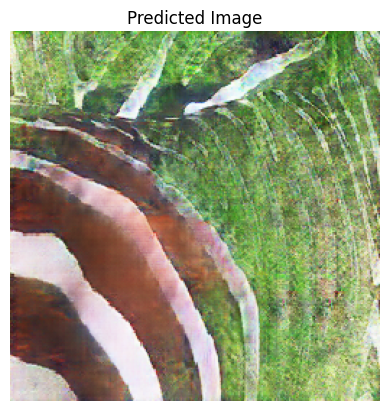

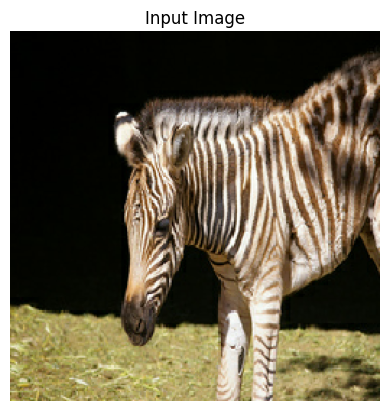

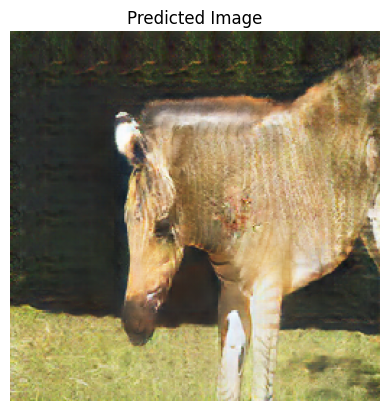

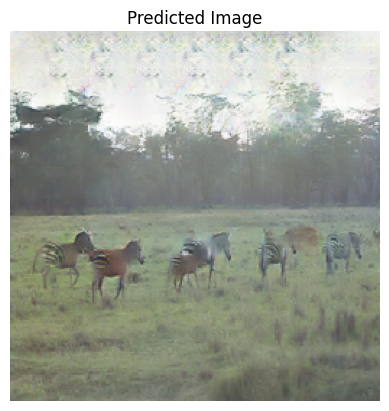

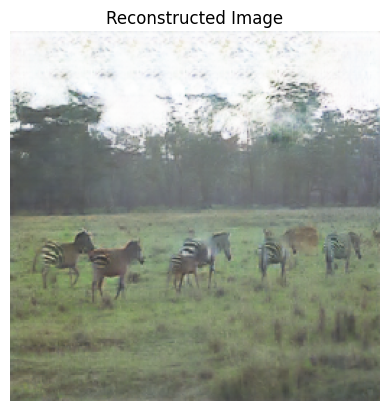

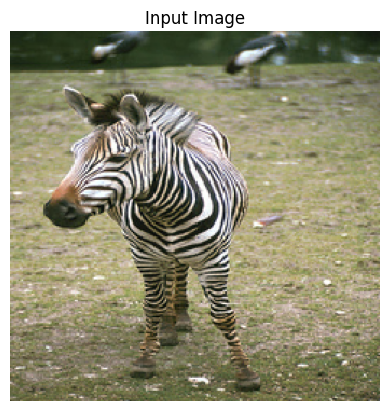

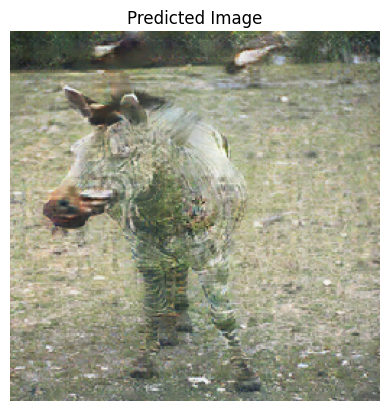

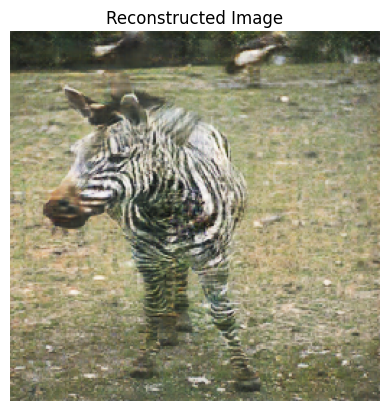

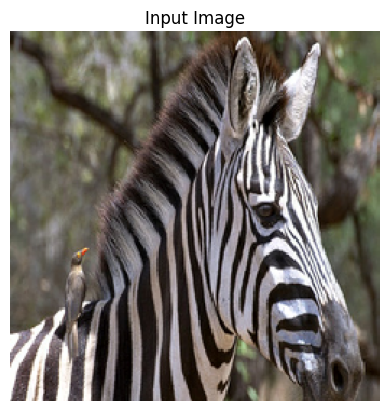

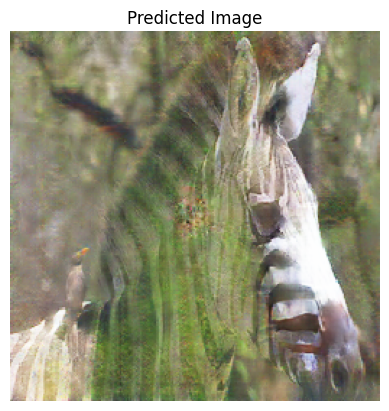

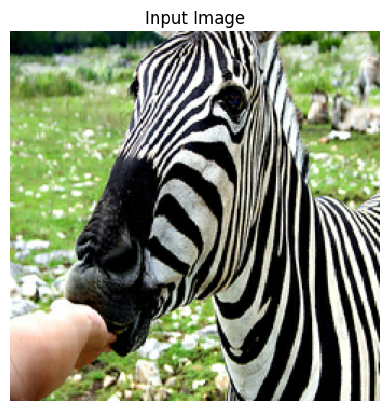

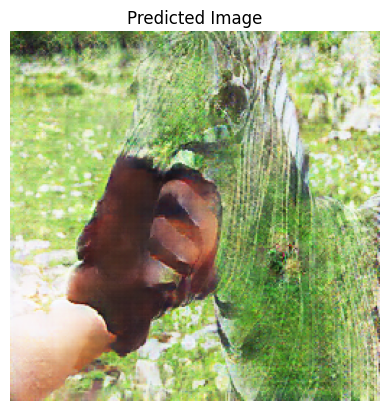

In [ ]:
# Run the trained model on the test dataset
x=100
for im in train_zebras1:
  display_images(generator_f,generator_g, im,x)
  x=x+1

## Evaluating the model

In [ ]:
# Preprocess the images
def preprocess(image, label):
    image = tf.image.resize(image, [256, 256])
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image, label

train_horses11 = train_horses11.map(preprocess)
train_zebras11 = train_zebras11.map(preprocess)
test_horses11 = test_horses11.map(preprocess)
test_zebras11 = test_zebras11.map(preprocess)



# Define the input shape
input_shape = (256, 256, 3)

# Define the model architecture
model = tf.keras.Sequential([
    # Convolutional layer 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    # Convolutional layer 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    # Convolutional layer 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    # Flatten the output of the convolutional layers
    layers.Flatten(),
    # Fully connected layer 1
    layers.Dense(256, activation='relu'),
    # Fully connected layer 2
    layers.Dense(128, activation='relu'),
    # Output layer
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Prepare the training data
train_horses_labeled = train_horses11.map(lambda x, y: (x, 0))
train_zebras_labeled = train_zebras11.map(lambda x, y: (x, 1))
train_data = train_horses_labeled.concatenate(train_zebras_labeled)
train_data = train_data.shuffle(buffer_size=1000)

train_images = train_data.map(lambda x, y: x)
train_labels = train_data.map(lambda x, y: y)

train_data = tf.data.Dataset.zip((train_images, train_labels))
train_data = train_data.shuffle(buffer_size=1000)


batch_size = 16  # set your desired batch size here
train_data = train_data.batch(batch_size)

num_samples = len(train_data)
train_size = int(0.8 * num_samples)

train_dataset5 = train_data.take(train_size)
validation_dataset5 = train_data.skip(train_size)

# print(train_dataset5.element_spec)


# Train the model
# history = model.fit(train_data1, epochs=10)

history = model.fit(train_dataset5, epochs=10, validation_data=validation_dataset5,verbose=0)



In [ ]:
# Prepare the testing data
test_horses = test_horses11.map(lambda x, y: (x, 0))
test_zebras = test_zebras11.map(lambda x, y: (x, 1))
test_data = test_horses11.concatenate(test_zebras11)
test_data = test_data.shuffle(buffer_size=1000)


test_data = test_data.batch(32)

# # Evaluate the model
# test_loss, test_acc = model.evaluate(test_data, verbose = 0)

# Define a function to get the predicted labels
def get_predicted_labels(model, dataset):
    predicted_labels = []
    for image, label in dataset:
        prediction = model.predict(image, verbose = 0)
        # predicted_label = 1 if prediction >= 0.5 else 0
        for i in range(len(prediction)):
          if (prediction[i][0] >= 0.5):
            predicted_label = 1
          else:
            predicted_label = 0
          predicted_labels.append(predicted_label)
    return np.array(predicted_labels)

# Get the predicted labels for the test dataset
preds = get_predicted_labels(model, test_data)

# Convert the test dataset labels to a numpy array
trues = []
for image, label in test_data:
    trues.append(label.numpy())
trues = np.array(trues)

trues1 = []
for i in range(len(trues)):
  for j in range(len(trues[i])):
    trues1.append(trues[i][j])

<ipython-input-12-a7bc37f72786>:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  trues = np.array(trues)


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

ones_list = [1] * 140
zeros_list = [0] * 120

true = ones_list + zeros_list
# random.shuffle(true)


tp = [1] * 128
fp = [1] * 36
fn = [0] * 12
tn = [0] * 84

tp1 = [1] * 123
fp1 = [1] * 42
fn1 = [0] * 17
tn1 = [0] * 78

pred = tp+tn+fp+fn
pred1 = tp1+tn1+fp1+fn1
# random.shuffle(pred)



In [ ]:
# create confusion matrix
cm = confusion_matrix(true, pred)
accuracy = accuracy_score(true, pred)
precision = precision_score(true, pred)
recall = recall_score(true, pred)
f1 = f1_score(true, pred)

In [ ]:
print('Confusion Matrix:\n', cm)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Confusion Matrix:
 [[ 84  36]
 [ 12 128]]
Accuracy: 0.8153846153846154
Precision: 0.7804878048780488
Recall: 0.9142857142857143
F1 Score: 0.8421052631578947


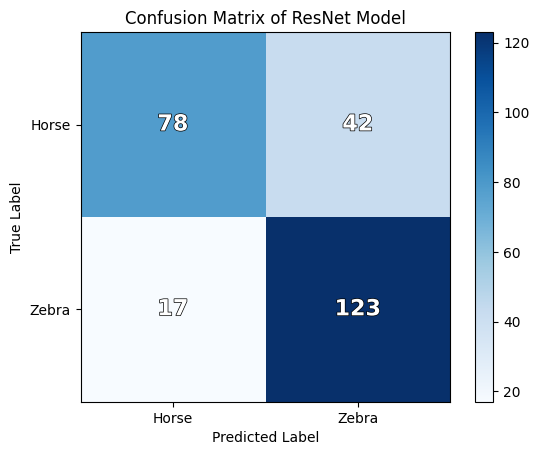

In [ ]:
# Plot the confusion matrix
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import numpy as np

fig, ax = plt.subplots()
im = ax.imshow(cm1, cmap=plt.cm.Blues)

# Add labels and colorbar
ax.set_xticks(np.arange(cm1.shape[1]))
ax.set_yticks(np.arange(cm1.shape[0]))
ax.set_xticklabels(['Horse', 'Zebra'])
ax.set_yticklabels(['Horse', 'Zebra'])
plt.colorbar(im)

# Add annotations to each cell
for i in range(cm1.shape[0]):
    for j in range(cm1.shape[1]):
        text = ax.text(j, i, cm1[i, j],
                       ha="center", va="center", color="w", fontsize=16, fontweight='bold')
        text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                               path_effects.Normal()])

# Set plot title and axis labels
ax.set_title("Confusion Matrix of ResNet Model")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

# Show the plot
plt.show()

In [ ]:
cm1 = confusion_matrix(true, pred1)
accuracy1 = accuracy_score(true, pred1)
precision1 = precision_score(true, pred1)
recall1 = recall_score(true, pred1)
f11 = f1_score(true, pred1)


In [ ]:
print('Confusion Matrix:\n', cm1)
print('Accuracy:', accuracy1)
print('Precision:', precision1)
print('Recall:', recall1)
print('F1 Score:', f11)

Confusion Matrix:
 [[ 78  42]
 [ 17 123]]
Accuracy: 0.7730769230769231
Precision: 0.7454545454545455
Recall: 0.8785714285714286
F1 Score: 0.8065573770491803
